In [1]:
#torch packages
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
#
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import trange,tqdm

In [2]:
# Size of our mini batch size
batch_size=128
num_epochs = 50
learning_rate =1e-4
data_set_root = './data'
patch_size =4

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
test_transforms=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])]) #Standard MNIST mean and std


In [4]:
train_data = datasets.CIFAR10(data_set_root,train=True,download =True, transform = transform)
test_data = datasets.CIFAR10(data_set_root,train=False,download =True, transform = test_transforms)

Validation_split =0.9

n_train_examples = int(len(train_data)*Validation_split)
n_valid_examples = len(train_data)-n_train_examples

train_data,valid_data = torch.utils.data.random_split(train_data,[n_train_examples,n_valid_examples],generator = torch.Generator().manual_seed(42))

100%|██████████| 170M/170M [00:05<00:00, 32.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print("# Train Data Examples------",len(train_data))
print("# Validation Data Examples------",len(valid_data))
print("# Test Data Examples------",len(test_data))


# Train Data Examples------ 45000
# Validation Data Examples------ 5000
# Test Data Examples------ 10000


In [6]:
train_dataloader = dataloader.DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_dataloader =dataloader.DataLoader(valid_data,batch_size=batch_size,shuffle=True)
test_dataloader = dataloader.DataLoader(test_data,batch_size=batch_size,shuffle=True)

 For simplicity, let’s consider a tensor with a shape of [1 x 1 x 3 x 3], where the first dimension is the batch size, the second is the number of channels, and the last two are the height and width of the tensor. If we define the unfold operation with a kernel size of (2,2), a block of this size will slide through the tensor, extracting values, flattening them, and moving to the next position. Initially, it will extract values [1, 2, 4, 5], then slide to [2, 3, 5, 6], and continue this process by sliding down. The resultant tensor would have a shape of [1 x 4 x 4], where 1 is the batch size, 4 represents (patch size * number of channels), and the last dimension indicates the number of blocks it has slid through. The exact formula for the output tensor is provided in the documentation (which I will link at the end). To obtain non-overlapping patches of the images, we need to ensure that there is no overlap while sliding. Therefore, we set the stride equal to the patch size so that while ‘unfolding,’ the block slides to a new position without any overlap. Once this operation is complete, we can reshape the tensor as desired using the ‘view’ function. Additionally, we can permute the channels of the resultant tensor to facilitate integration with next operations discussed later. In the end, we obtain a tensor of shape: [Batch_size x No. of patches x No. of Channels x patch height x patch width].

In [7]:
def extract_patches(img, patch_size,p=False):

    bs,c,h,w = img.shape

    unfold = torch.nn.Unfold(kernel_size=patch_size,stride=patch_size)
    #stride = patch_size to avoid overlap
    unfolded = unfold(img)
    if p:
        print("Actual shape",img.shape)
        print("shape of unfolded",unfolded.shape)
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    if p:
        print("shape of permuted unfolded",unfolded.shape)

    return unfolded



In [8]:
dataiter = next(iter(test_dataloader))
test_imgs,test_labels = dataiter

32 x 32/ 4 x 4 = 64 ~ NO of Patches


In VIT paper  dataset of (B,C,H,W) are patchified
into  (N,P x P xC)
SO N ~ (H x W)/P x P

Actual shape torch.Size([128, 3, 32, 32])
shape of unfolded torch.Size([128, 48, 64])
shape of permuted unfolded torch.Size([128, 64, 48])
patches_square beforetorch.Size([128, 64, 48]) and after torch.Size([128, 64, 3, 4, 4])
Sequence length 64


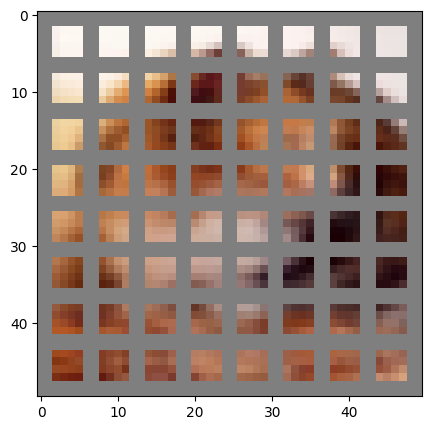

In [9]:
patches = extract_patches(test_imgs, patch_size=patch_size,p=True)
patches_square = patches.reshape(test_imgs.shape[0],-1,3,patch_size,patch_size)
print(f"patches_square before{patches.shape} and after {patches_square.shape}")
grid_size = test_imgs.shape[2]//(patch_size)
print("Sequence length",grid_size**2)

plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

# Model Architecture

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size =128, num_heads=4) -> None:
        super(TransformerBlock,self).__init__()

        self.norm1 = nn.LayerNorm(hidden_size)
        self.multiheadattn = nn.MultiheadAttention(hidden_size,num_heads,batch_first=True,dropout=0.1)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
    def forward(self,x):
        # print(f"Input shape to TransformerBlock: {x.shape}")
        # print(f"Input type to TransformerBlock: {type(x)}")
        norm_x = self.norm1(x)
        # print(f"Output shape of norm1: {norm_x.shape}") # check norm1 output
        x = self.multiheadattn(norm_x, norm_x, norm_x)[0]
        # print(f"Output shape of multiheadattn: {x.shape}") # check multiheadattn output
        x = x + norm_x
        norm_x = self.norm2(x)
        # print(f"Output shape of norm2: {norm_x.shape}") # check norm2 output
        x = self.mlp(norm_x)
        # print(f"Output shape of mlp: {x.shape}") # check mlp output
        x = x + norm_x
        return x

class ViT(nn.Module):
    def __init__(self,img_size,channels_in,patch_size,hidden_size,num_layers,num_heads=8):
        super(ViT,self).__init__()

        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(hidden_size, 10) #CIFAR 10 classes

        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        seq_length = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))
    def forward(self,img):

        bs =img.shape[0]
        patch_seq = extract_patches(img, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)
        patch_emb = patch_emb + self.pos_embedding
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        for block in self.blocks:
            embs = block(embs)

        return self.fc_out(embs[:, 0])



In [11]:
# Create a dataloader itterable object
dataiter = next(iter(train_dataloader))
# Sample from the itterable object
train_images, train_labels = dataiter

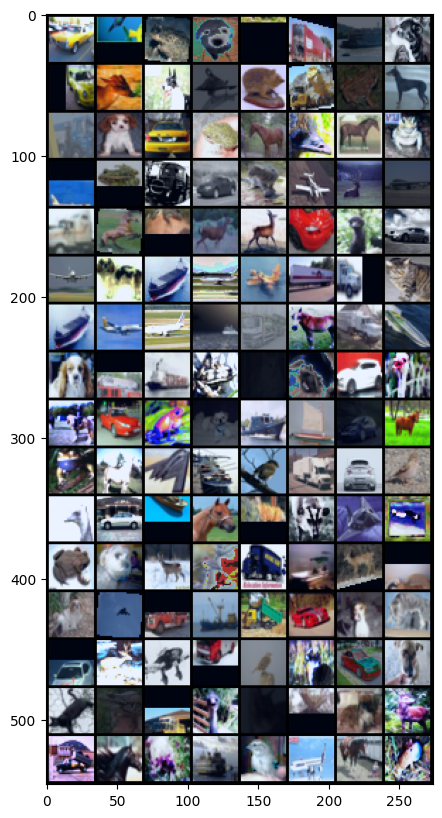

In [12]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [13]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = ViT(img_size=test_imgs.shape[2],
            channels_in=test_imgs.shape[1],
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

ViT(
  (fc_in): Linear(in_features=48, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (multiheadattn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))



-This Model Has 1079818 (Approximately 1 Million) Parameters!


In [15]:
out = model(test_imgs.to(device))
# Check output
out.shape

torch.Size([128, 10])

#Optimizer and Loss

In [16]:
# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=num_epochs,
                                                    eta_min=0)

In [17]:
# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()


In [18]:
def train(model, optimizer, loader, device, loss_fun, loss_logger):

    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))

        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()

        # Log the loss for plotting
        loss_logger.append(loss.item())

    # Return the avaerage loss and acc from the epoch as well as the logger array
    return model, optimizer, loss_logger

In [19]:
def evaluate(model, device, loader):

    # Initialise counter
    epoch_acc = 0

    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))

            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()

    # Return the accuracy from the epoch
    return epoch_acc / len(loader.dataset)


#Training process

In [20]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []



In [21]:
valid_acc = 0
train_acc = 0

# This cell implements our training loop
pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_dataloader,
                                                   device=device,
                                                   loss_fun=loss_fun,
                                                   loss_logger=training_loss_logger)

    # Call the evaluate function and pass the dataloader for both validation and training
    train_acc = evaluate(model=model, device=device, loader=train_dataloader)
    valid_acc = evaluate(model=model, device=device, loader=valid_dataloader)

    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

    # Reduce learning rate
    lr_scheduler.step()

print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Training Complete


In [22]:
torch.save(model, 'model.pth')

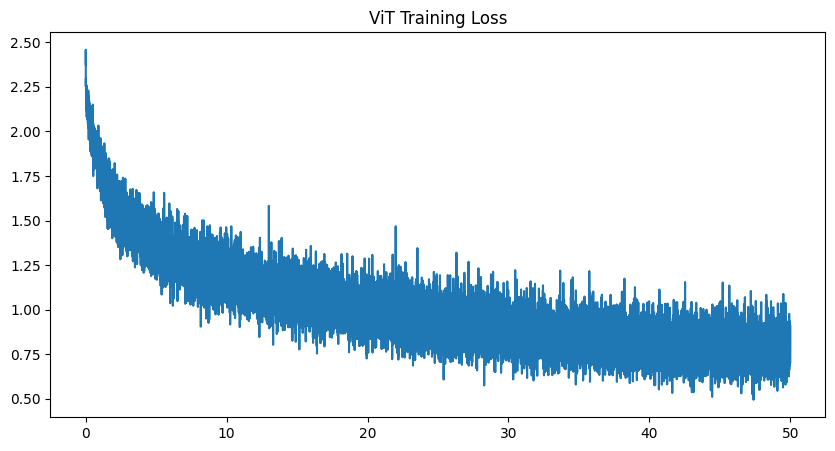

In [23]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("ViT Training Loss")

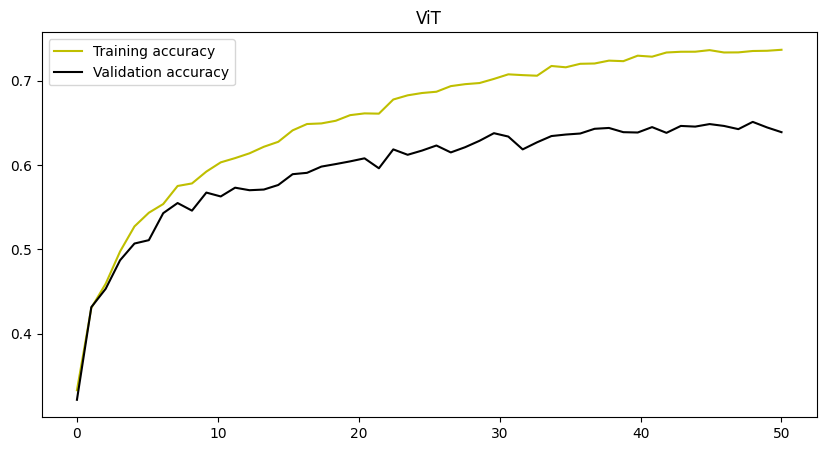

In [24]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("ViT")
_ = plt.legend(["Training accuracy", "Validation accuracy"])


#Testing  

In [25]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_dataloader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

The total test accuracy is: 72.50%


Predicted Values
 [3, 1, 0, 2, 5, 9, 9, 0]
True Values
 [3, 1, 3, 2, 3, 1, 9, 0]


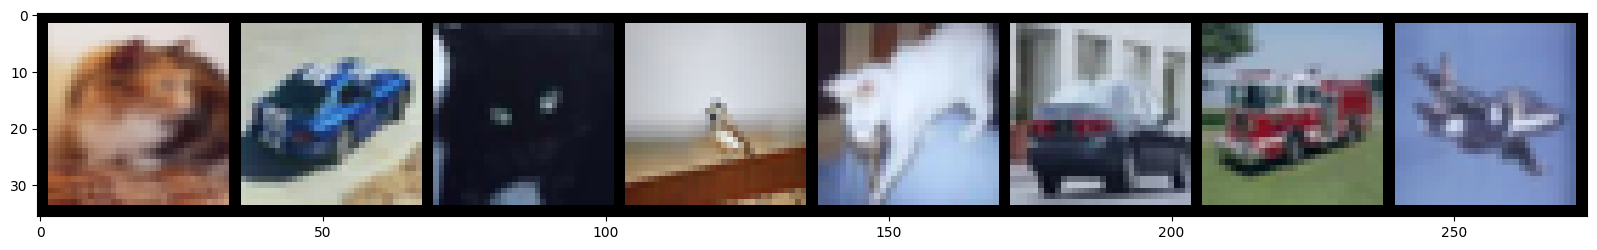

In [26]:
with torch.no_grad():
    fx = model(test_imgs[:8].to(device))
    pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_imgs[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))
